In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, Model

# =============================
# 1. CHARGEMENT DES DONNÉES
# =============================
df = pd.read_csv("meteofrance.csv", sep=';')
cols = ['AAAAMMJJHH', 'U', ' T','PSTAT']
df = df[cols]

df.rename(columns={
    'AAAAMMJJHH' : 'date' ,
    'U': 'humidity',
    ' T': 'temperature',
    'PSTAT': 'pressure'
}, inplace=True)
cols = ['humidity', 'temperature', 'pressure']
print("Colonnes dispo :", df.columns)
df_feat = df[cols].copy()
missing_codes = [-999.9, 9999, -99.9]
df_feat = df_feat.replace(missing_codes, np.nan)
df_feat = df_feat.interpolate().dropna()
indices_valid = df_feat.index
X = df_feat.values
print("Shape des données (n_samples, n_features) :", X.shape)

# =============================
# 2. NORMALISATION
# =============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
input_dim = X_scaled.shape[1]   # = 3

Colonnes dispo : Index(['date', 'humidity', 'temperature', 'pressure'], dtype='object')
Shape des données (n_samples, n_features) : (644757, 3)


In [5]:
# =============================
# 3. DEFINITION DU GAN
# =============================

latent_dim = 8   # dimension du bruit d’entrée du générateur
# ----- Générateur -----
def build_generator(latent_dim, output_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)  # données standardisées
    return Model(inputs, outputs, name="generator")

# ----- Discriminateur -----
def build_discriminator(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # probabilité "réel"
    return Model(inputs, outputs, name="discriminator")

generator = build_generator(latent_dim, input_dim)
discriminator = build_discriminator(input_dim)

discriminator.summary()
generator.summary()

# ----- Compilation du discriminateur -----
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----- Modèle GAN combiné (G + D) -----
# On gèle D dans ce modèle-là : on ne l'entraîne pas quand on entraîne G
discriminator.trainable = False

z_input = layers.Input(shape=(latent_dim,))
fake_x = generator(z_input)
validity = discriminator(fake_x)

gan = Model(z_input, validity, name="gan")
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy'
)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673 (2.63 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787 (3.07 KB)

 Trainable params: 787 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 0/1000 - D loss: 0.6918, acc: 0.0008 - G loss: 0.6210
Epoch 100/1000 - D loss: 0.7111, acc: 0.0005 - G loss: 0.6001
Epoch 200/1000 - D loss: 0.7334, acc: 0.0003 - G loss: 0.5780
Epoch 300/1000 - D loss: 0.7588, acc: 0.0002 - G loss: 0.5562
Epoch 400/1000 - D loss: 0.7878, acc: 0.0002 - G loss: 0.5350
Epoch 500/1000 - D loss: 0.8197, acc: 0.0002 - G loss: 0.5149
Epoch 600/1000 - D loss: 0.8549, acc: 0.0001 - G loss: 0.4966
Epoch 700/1000 - D loss: 0.8922, acc: 0.0001 - G loss: 0.4804
Epoch 800/1000 - D loss: 0.9303, acc: 0.0001 - G loss: 0.4665
Epoch 900/1000 - D loss: 0.9676, acc: 0.0001 - G loss: 0.4546


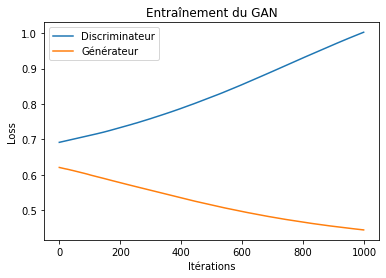

In [7]:

# Hyperparamètres d'entraînement
epochs = 1000        # tu peux ajuster (500–5000 selon le temps)
batch_size = 64
n_samples = X_scaled.shape[0]

# Labels pour le training
real_label = 0.9   # "label smoothing" pour plus de stabilité
fake_label = 0.0

d_losses = []
g_losses = []

for epoch in range(epochs):
    # ---- 1. Entraînement du discriminateur ----
    # On prend un mini-batch réel
    idx = np.random.randint(0, n_samples, batch_size)
    real_batch = X_scaled[idx]

    # On génère un batch faux avec le générateur
    z = np.random.normal(size=(batch_size, latent_dim))
    fake_batch = generator.predict(z, verbose=0)

    # Labels
    y_real = np.ones((batch_size, 1)) * real_label
    y_fake = np.zeros((batch_size, 1)) * fake_label

    # Entraînement de D sur réel + faux
    d_loss_real = discriminator.train_on_batch(real_batch, y_real)
    d_loss_fake = discriminator.train_on_batch(fake_batch, y_fake)
    d_loss = 0.5 * (np.array(d_loss_real) + np.array(d_loss_fake))

    # ---- 2. Entraînement du générateur via le GAN ----
    # On veut que G trompe D -> labels "réels" pour des échantillons générés
    z = np.random.normal(size=(batch_size, latent_dim))
    y_gen = np.ones((batch_size, 1)) * real_label
    g_loss = gan.train_on_batch(z, y_gen)

    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - D loss: {d_loss[0]:.4f}, acc: {d_loss[1]:.4f} - G loss: {g_loss:.4f}")

# Courbes de loss
plt.figure()
plt.plot(d_losses, label="Discriminateur")
plt.plot(g_losses, label="Générateur")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.legend()
plt.title("Entraînement du GAN")
plt.show()

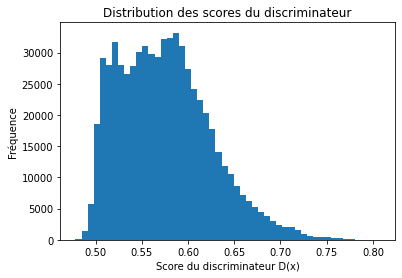

Seuil de score D(x) pour anomalie : 0.497295081615448
Nombre d'anomalies détectées : 6448 / 644757


In [8]:
# =============================
# 5. SCORE D'ANOMALIE AVEC LE DISCRIMINATEUR
# =============================

# On fait passer TOUTES les données par le discriminateur
D_scores = discriminator.predict(X_scaled, verbose=0)  # probas d'être "réel"

D_scores = D_scores.flatten()
plt.hist(D_scores, bins=50)
plt.xlabel("Score du discriminateur D(x)")
plt.ylabel("Fréquence")
plt.title("Distribution des scores du discriminateur")
plt.show()

# Ici : plus D(x) est PETIT, plus x est suspect
# On choisit un seuil, par ex. 1er percentile (les 1% plus petits scores)
threshold = np.percentile(D_scores, 1)
print("Seuil de score D(x) pour anomalie :", threshold)

anomaly_mask = D_scores < threshold
n_anomalies = np.sum(anomaly_mask)
print("Nombre d'anomalies détectées :", n_anomalies, "/", len(D_scores))

X_anom_scaled = X_scaled[anomaly_mask]
indices_anom = indices_valid[anomaly_mask]

/home/cheikh/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Répartition des anomalies par cluster :
Cluster 0 : 2602 anomalies
Cluster 1 : 1775 anomalies
Cluster 2 : 2071 anomalies


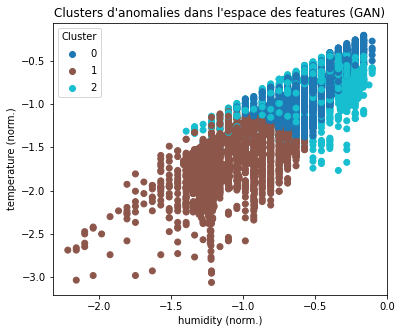

Exemple d'anomalies détectées (GAN) :
     humidity  temperature  pressure  cluster   D_score
365      69.0         10.2    1008.3        2  0.494887
449      67.0          6.1    1004.4        2  0.490587
461      62.0          6.2    1000.3        2  0.491219
466      67.0          7.1    1003.6        2  0.494568
474      64.0          6.1    1006.0        2  0.484742


In [9]:
# =============================
# 6. CLUSTERING DES ANOMALIES (FACULTATIF, DANS L'ESPACE DES FEATURES)
# =============================

if n_anomalies > 0:
    n_clusters = 3  # tu peux mettre auto comme avec le VAE, ou laisser 3 pour commencer
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels_anom = kmeans.fit_predict(X_anom_scaled)

    print("Répartition des anomalies par cluster :")
    for k in range(n_clusters):
        print(f"Cluster {k} : {(labels_anom == k).sum()} anomalies")

    # Visualisation 2D rapide (on projette sur les 2 premières features)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_anom_scaled[:, 0], X_anom_scaled[:, 1], c=labels_anom, cmap="tab10")
    plt.xlabel(cols[0] + " (norm.)")
    plt.ylabel(cols[1] + " (norm.)")
    plt.title("Clusters d'anomalies dans l'espace des features (GAN)")
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.show()
else:
    labels_anom = np.array([])
    print("Aucune anomalie détectée avec ce seuil.")

# =============================
# 7. RETOUR AUX VALEURS PHYSIQUES
# =============================

X_anom_original = scaler.inverse_transform(X_anom_scaled)

anom_df = pd.DataFrame(
    X_anom_original,
    columns=cols,
    index=indices_anom
)

if n_anomalies > 0:
    anom_df["cluster"] = labels_anom
    anom_df["D_score"] = D_scores[anomaly_mask]

print("Exemple d'anomalies détectées (GAN) :")
print(anom_df.head())
